## CS 584 Machine Learning : Homework Project: Crime Prediction
---
### Team Members:
 * Jadhav Aditya
 * Sumedha Gupta


In [23]:
import pandas as pd # panda's nickname is pd
import numpy as np
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from  sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import binarize
import matplotlib.pyplot as plot
from sklearn import linear_model
from IPython.display import Image 
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn import tree
import sklearn.preprocessing as prep
import pydotplus 
import math
from sklearn.linear_model import RidgeCV
import sklearn.linear_model as linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

#### Load the communities-crime-clean.csv file into a dataframe object


In [24]:
communities_crime_df = pd.read_csv('communities-crime-clean.csv')

# Sanity test we have good data
communities_crime_df.head()


,state,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,1,Alabastercity,7,0.01,0.61,0.21,0.83,0.02,0.01,0.41,...,0.03,0.70,0.40,0.34,0.57,0.05,0.06,0.01,0.0,0.06
1,1,AlexanderCitycity,10,0.01,0.41,0.55,0.57,0.01,0.00,0.47,...,0.00,0.93,0.66,0.82,0.84,0.11,0.03,0.01,0.0,0.14
2,1,Annistoncity,3,0.03,0.34,0.86,0.30,0.04,0.01,0.41,...,0.04,0.77,0.59,0.70,0.64,0.06,0.11,0.04,0.0,1.00
3,1,Athenscity,8,0.01,0.38,0.35,0.71,0.04,0.01,0.39,...,0.03,0.78,0.56,0.67,0.71,0.09,0.05,0.00,0.0,0.23
4,1,Auburncity,1,0.04,0.37,0.32,0.70,0.21,0.02,1.00,...,0.12,0.49,0.12,0.00,0.15,0.09,0.09,0.01,0.0,0.15


### Q1. Decision Trees
---
#### a) Create a new field “highCrime” which is true if the crime rate per capita (ViolentCrimesPerPop) is greater than 0.1, and false otherwise. What are the percentage of positive and negative instances in the dataset?

In [25]:
def setHighCrime(df):
    '''Function to set value of highCrime depending on ViolentCrimesPerPop'''
    if df['ViolentCrimesPerPop'] > 0.1:
        return True
    else:
        return False
    
# Adding a new field "highCrime"
communities_crime_df['highCrime'] = communities_crime_df.apply(setHighCrime, axis=1)

# Calculating the percentage of positive and negative instances in the dataset
percentage_intances = communities_crime_df.groupby('highCrime').size() * 100 / len(communities_crime_df)
print(percentage_intances)
print("------------------")
print("Percentage Positive Instance = {}\nPercentage Negative Instance = {} ".format(percentage_intances[1],percentage_intances[0]))


highCrime
False    37.280482
True     62.719518
dtype: float64
------------------
Percentage Positive Instance = 62.719518314099346
Percentage Negative Instance = 37.280481685900654 


#### b) Use DecisionTreeClassifier to learn a decision tree to predict highCrime on the entire dataset  
##### i. What are the training accuracy, precision, and recall for this tree?

In [26]:
#Dropping non-predictive fields as well as ViolentCrimesPerPop field 
X = communities_crime_df.drop('ViolentCrimesPerPop', axis=1).drop('state', axis=1).drop('communityname', axis=1).drop('fold', axis=1).drop('highCrime', axis=1)
features = list(X.columns)
y = communities_crime_df["highCrime"]


# First, we tried by not defining the max depth
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X,y)
predicted = dt_clf.predict(X[features])
recall_score = metrics.recall_score(communities_crime_df['highCrime'], predicted)
precision_score = metrics.precision_score(communities_crime_df['highCrime'], predicted)
accuracy_score = metrics.accuracy_score(communities_crime_df['highCrime'], predicted)
print("Training Accuracy = {} Precision = {} Recall = {}".format(accuracy_score,precision_score,recall_score))

Training Accuracy = 1.0 Precision = 1.0 Recall = 1.0


#### The scores values shows overfitting so we can define max_depth to avoid the complexity of the tree and to reach a point from where there is a decrease in the cross validation performance.

In [27]:
for depth in range(1,10):
    tree_clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
    if tree_clf.fit(X,y).tree_.max_depth < depth:
        break
    score = np.mean(cross_val_score(tree_clf, X, y,scoring='accuracy', cv=10, n_jobs=1))
    print("Depth: %i Accuracy: %.3f" % (depth,score))

Depth: 1 Accuracy: 0.761
Depth: 2 Accuracy: 0.776
Depth: 3 Accuracy: 0.798
Depth: 4 Accuracy: 0.790
Depth: 5 Accuracy: 0.779
Depth: 6 Accuracy: 0.768
Depth: 7 Accuracy: 0.763
Depth: 8 Accuracy: 0.746
Depth: 9 Accuracy: 0.744


#### We can see that the point up to which the performance is increasing is the depth 3. We can specify the depth and witness the results.

In [28]:
dt_clf = DecisionTreeClassifier(max_depth=3)
dt_clf.fit(X,y)
#Predicting 
pred_dt= dt_clf.predict(X)
dt_accuracy= metrics.accuracy_score(communities_crime_df['highCrime'], pred_dt)
dt_precision= metrics.precision_score(communities_crime_df['highCrime'], pred_dt)
dt_recall= metrics.recall_score(communities_crime_df['highCrime'], pred_dt)
print("Accuracy for DT =",dt_accuracy)
print("Precision for DT =",dt_precision)
print("Recall for DT =",dt_precision)

Accuracy for DT = 0.83592574009
Precision for DT = 0.900260190807
Recall for DT = 0.900260190807


##### ii. What are the main features used for classification? Can you explain why they make sense (or not)?

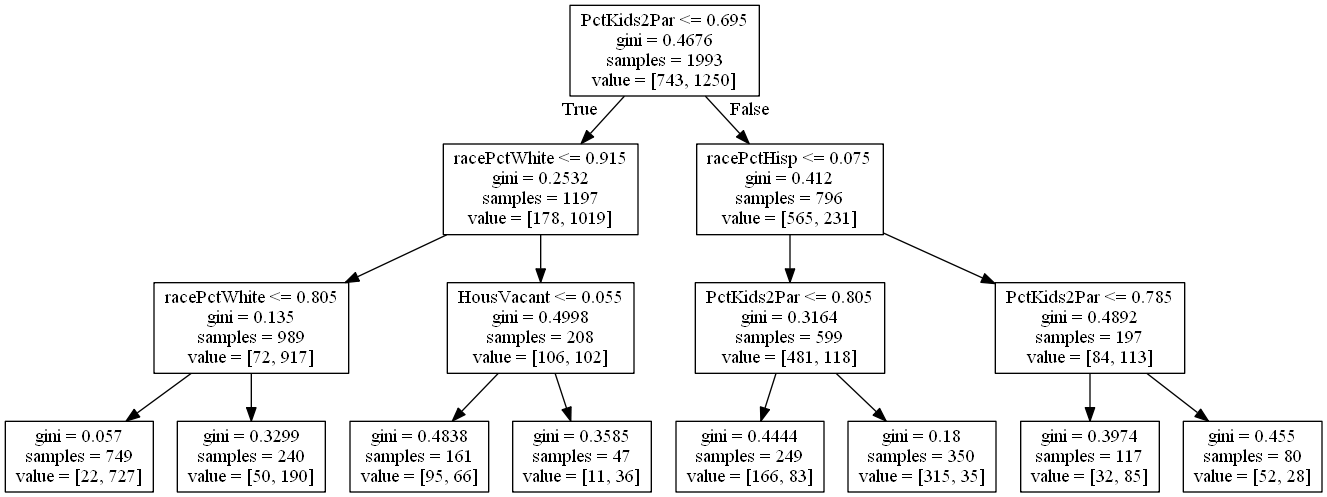

In [29]:
dot_data = tree.export_graphviz(dt_clf, out_file=None,feature_names=list(X))

graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 

In [30]:
# We can check the main features used for classification by checking the feature importance, the higher the value,
# more important the feature would be.
# We can sort the importance scores in descending order and take the top most.
importances=dt_clf.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
# We have taken the top 5 feature 
print("The main features used for classification")
print(X.columns[indices[:5]])
print("Top main feature is",X.columns[indices[:1]][0])

Feature ranking:
The main features used for classification
Index(['PctKids2Par', 'racePctWhite', 'racePctHisp', 'HousVacant',
       'LemasPctOfficDrugUn'],
      dtype='object')
Top main feature is PctKids2Par


#### The top main feature is PctKids2Par because it is the split point of the tree. This feature depicts the kids with two parents.

#### c. Now apply cross-validation (cross_val_score) to do 10-fold cross-validation to estimate the out-of-training accuracy of decision tree learning for this task.  
##### i. What are the 10-fold cross-validation accuracy, precision, and recall?

In [31]:
# Applying 10 fold cross validation
dt_cv_accuracy = cross_val_score(dt_clf, X, y, cv=10).mean()
dt_cv_precision= cross_val_score(dt_clf, X, y, cv=10, scoring='precision').mean()
dt_cv_recall = cross_val_score(dt_clf, X, y, cv=10, scoring='recall').mean()
print("Cross Validation Accuracy DT:", dt_cv_accuracy)
print("Cross Validation Recall DT:", dt_cv_precision)
print("Cross Validation Precision DT:", dt_cv_recall)


Cross Validation Accuracy DT: 0.798243718593
Cross Validation Recall DT: 0.843267479959
Cross Validation Precision DT: 0.8392


##### ii. Why are they different from the results in the previous test?
We use cross-validation to get a better estimate of the generalization error on new unseen data where as the common problem that is in Decision trees is overfitting, in which many training examples are fitting the training data perfectly or nearly perfectly which leads to an overly specific model and lower performance. Thus, we
contrained the tree to include only up to three levels, since a simple tree is more general. Thus, the results obtained after specifying are more realistic.
These results are different from cross validation results as the train and test data are different in cross validation on the other hand DT train on all the exmaples.

### 2. Linear Classification
---
#### a. Use GaussianNB to learn a Naive Bayes classifier to predict highCrime.  
##### i. What is the 10-fold cross-validation accuracy, precision, and recall for this method?

In [32]:
# Using GaussianNB
gaussian_clf = GaussianNB()
gaussian_clf.fit(X, y)

# Applying 10 fold cross validation
gaussian_accuracy = cross_val_score(gaussian_clf, X, y, cv=10).mean()
gaussian_precision= cross_val_score(gaussian_clf, X, y, cv=10, scoring='precision').mean()
gaussian_recall = cross_val_score(gaussian_clf, X, y, cv=10, scoring='recall').mean()
print("Accuracy for gaussian :", gaussian_accuracy)
print("Recall for gaussian:", gaussian_recall)
print("Precision for gaussian:", gaussian_precision)


Accuracy for gaussian : 0.761608040201
Recall for gaussian: 0.692
Precision for gaussian: 0.911799814828


What are the 10 most predictive features? This can be
measured by the normalized absolute difference of means for
the feature between the two classes:
|𝜇𝑇 − 𝜇𝐹|/𝜎𝑇 + 𝜎𝐹
The larger this different, the more predictive the feature. Why
do these make sense (or not)?

In [33]:
df_predictiveFeature = communities_crime_df.drop('state', axis=1).drop('communityname', axis=1).drop('fold', axis=1)

dictPredFeature = {}
# Collecting data for the two classes
true_df = X[df_predictiveFeature['highCrime'] == 1]
false_df = X[df_predictiveFeature['highCrime'] == 0]
for column in X:
    mean_true = true_df[column].mean()
    mean_false = false_df[column].mean()
    var_true = true_df[column].var()
    var_false = false_df[column].var()
    if(column != 'highCrime'):
        predScore = abs((mean_true - mean_false))/(math.sqrt(var_true)+math.sqrt(var_false))
        dictPredFeature[column] = predScore
most_pred_features = sorted(dictPredFeature.items(), key=lambda x: x[1])[-10:]
for i in most_pred_features:
    print(i)


('MalePctDivorce', 0.6165342437579264)
('PctTeen2Par', 0.6426208020335665)
('pctWInvInc', 0.6607203219208594)
('PctYoungKids2Par', 0.6646705535981033)
('TotalPctDiv', 0.6742823162675443)
('FemalePctDiv', 0.6936040623575482)
('PctIlleg', 0.7089291060645266)
('racePctWhite', 0.7348840522379364)
('PctFam2Par', 0.74516152011997)
('PctKids2Par', 0.8093364216318364)


##### iii. How do these results compare with your results from decision trees, above?
We have plotted the results obtained.  

We can see that the accuracy and recall are higher in case of Decision Trees but the precision is higher in case of Gaussian NB.
We have to consider different criteria for choosing a classifier depending upon what we are predicting. Accuracy is not always the most appropriate method to choose the classifier. Here, in case of Crime Prediction, Precision would be the best criteria to compare and it is higher in case of Gaussian NB so the results are better in this case.

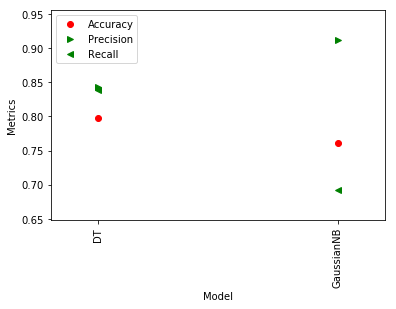

In [34]:
labels = ["DT" ,"GaussianNB"]
acc_list = [dt_cv_accuracy,gaussian_accuracy]
pre_list = [dt_cv_precision,gaussian_precision]
re_list = [dt_cv_recall,gaussian_recall]

x_axis_range = range(2)
plt.xticks(x_axis_range, labels, rotation='vertical')
# plt.legend()

plt.plot(x_axis_range,acc_list,'ro',color="Red",label="Accuracy")
plt.plot(x_axis_range,pre_list,'>',color="green",label="Precision")
plt.plot(x_axis_range,re_list,'<',color="green",label="Recall")

plt.xlabel('Model')
plt.ylabel('Metrics')
plt.margins(0.2)
plt.subplots_adjust(bottom=0.15)
legend = plt.legend()
plt.show()

#### b. Use LinearSVC to learn a linear Support Vector Machine model to predict highCrime.
##### i. What is the 10-fold cross-validation accuracy, precision, and recall for this method?

In [35]:
linearsvmclf = svm.SVC(kernel='linear', C =1.0)
accuracy_svm = cross_val_score(linearsvmclf, X, y, cv=10, scoring='accuracy').mean()
precision_svm = cross_val_score(linearsvmclf, X, y, cv=10, scoring='precision').mean()
recall_svm = cross_val_score(linearsvmclf, X, y, cv=10, scoring='recall').mean()
print ('Accuracy for LinearSVC is', accuracy_svm)
print ('Precision for LinearSVC is', precision_svm)
print ('Recall for LinearSVC is', recall_svm)

Accuracy for LinearSVC is 0.804753768844
Precision for LinearSVC is 0.855179372789
Recall for LinearSVC is 0.8376


#### ii. What are the 10 most predictive features? This can be measured by the absolute feature weights in the model. Why do these make sense (or not)?

In [36]:
linearsvmclf.fit(X,y)

linearsvmclf_coef_array = {}
count = 0
for i in X.columns:
    linearsvmclf_coef_array[i] = abs(linearsvmclf.coef_[0][count])
    count = count+ 1

most_predictive_features = sorted(linearsvmclf_coef_array.items(), key=lambda x: x[1])[-10:]
most_predictive_features


[('agePct12t21', 0.98442987941004556),
 ('RentHighQ', 0.99163825361111957),
 ('PersPerOccupHous', 1.0275543973528991),
 ('MalePctDivorce', 1.073578841827074),
 ('population', 1.1086454264275147),
 ('PctFam2Par', 1.5426528869036265),
 ('racepctblack', 1.7203177655788284),
 ('PctKids2Par', 2.0576723456134776),
 ('racePctWhite', 2.2351581784693813),
 ('pctWInvInc', 2.3861552101921903)]

#### iii. How do these results compare with your results from decision trees, above?

We have plotted the results obtained from linear SVM and DT.  
We can see that the accuracy and recall are higher in case of Decision Trees but the precision is higher in case of linear SVM.
Precision would be the best criteria to compare and it is higher in case of linear SVM so the results are better in this case.

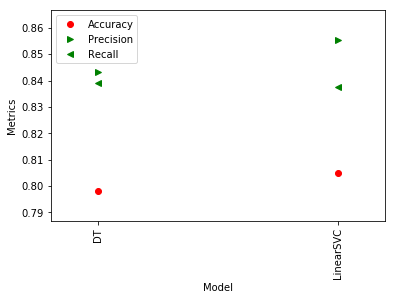

In [37]:
labels = ["DT" ,"LinearSVC"]
acc_list = [dt_cv_accuracy,accuracy_svm]
pre_list = [dt_cv_precision,precision_svm]
re_list = [dt_cv_recall,recall_svm]

x_axis_range = range(2)
plt.xticks(x_axis_range, labels, rotation='vertical')
# plt.legend()

plt.plot(x_axis_range,acc_list,'ro',color="Red",label="Accuracy")
plt.plot(x_axis_range,pre_list,'>',color="green",label="Precision")
plt.plot(x_axis_range,re_list,'<',color="green",label="Recall")

plt.xlabel('Model')
plt.ylabel('Metrics')
plt.margins(0.2)
plt.subplots_adjust(bottom=0.15)
legend = plt.legend()
plt.show()

### 3. Regression
#### a. Use LinearRegression to learn a linear model directly predicting the crime rate per capita (ViolentCrimesPerPop).
##### i. Using 10-fold cross-validation, what is the estimated meansquared- error (MSE) of the model?

In [38]:
Y = communities_crime_df['ViolentCrimesPerPop']
linear_regression = LinearRegression()
#df = df.drop('highCrime', 1)
mean_sq_err= cross_val_score(linear_regression,X, Y,None,scoring='neg_mean_squared_error',cv=10)
print("Estimated meansquared- error (MSE) of the model is",np.abs(mean_sq_err.mean()))

Estimated meansquared- error (MSE) of the model is 0.0200939693044


##### ii. What is the MSE on the training set (train on all the data then test on it all)?

In [39]:
linear_regression.fit(X,Y)
print("MSE on the training set is {}".format(np.mean((linear_regression.predict(X) - Y) ** 2)))

MSE on the training set is 0.016516774880307207


##### iii. What features are most predictive of a high crime rate? A low crime rate?
We can check the most predictive features by checking the coefficients, the larger the coeff, more predictive the feature.

In [40]:
# Taking the coefficients in an array
list_coef = np.array(linear_regression.coef_)


print("Most Predictive Feature of a High Crime Rate is", X.columns[np.argmax(list_coef)])
print("Most Predictive Feature of a Low Crime Rate is", X.columns[np.argmin(list_coef)])

Most Predictive Feature of a High Crime Rate is PersPerOccupHous
Most Predictive Feature of a Low Crime Rate is PctPersOwnOccup


#### b.Now use Ridge regression to reduce the amount of overfitting, using RidgeCV to pick the best alpha from among (10, 1, 0.1, 0.01, and 0.001).


In [41]:
clf = RidgeCV(alphas=(10, 1, 0.1, 0.01, 0.001))
clf.fit(X, Y)
print("Best alpha", clf.alpha_)  

#Other way to find out best aplha 
#alphas = np.array([10, 1, 0.1, 0.01, 0.001])
#model = Ridge()
#grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))
#grid.fit(X, Y)
#print(grid.best_estimator_.alpha)

Best alpha 1.0


##### i. What is the estimated MSE of the model under 10-fold CV?

In [42]:
ridge_clf = linear_model.Ridge(alpha=1.0)
ridge_clf.fit(X,Y)
mean_sq_err= cross_val_score(ridge_clf,X, Y,None,scoring='neg_mean_squared_error',cv=10)
print("Estimated meansquared- error (MSE) of the model is",np.abs(mean_sq_err.mean()))


Estimated meansquared- error (MSE) of the model is 0.0197950213482


##### ii. What is the MSE on the training set (train on all the data then test on it all)?

In [43]:

print("MSE on the training set is {0:0.2f}".format(np.mean((ridge_clf.predict(X) - Y) ** 2)))

#ridge_reg=linear_model.Ridge(alpha = 0.001)
#ridge_reg.fit(X,Y)

#print("Mean squared error: %.2f"
#      % np.mean((ridge_reg.predict(X) - Y) ** 2))
#print("MSE on the training set is {}".format(np.mean((ridge_reg.predict(X) - Y) ** 2)))

MSE on the training set is 0.02


####  iii. What is the best alpha?
We have calculate the best alpha using RidgeCV and re-verified by using GridSearchCV.  

The best alpha is 1.

#### iv. What does this say about the amount of overfitting in linear regression for this problem?

#### c. Now use polynomial features to do quadratic (second-order) polynomial regression.
##### i.What is the estimated MSE of the model under 10-fold CV?

In [44]:
poly_feature = PolynomialFeatures(degree  = 2, interaction_only = False)
poly_df = poly_feature.fit_transform(X)
ridge_clf.fit(poly_df,y)
## caluclating MSE
poly_mse= cross_val_score(linear_regression, poly_df, Y,None,scoring='neg_mean_squared_error',cv=10)
print("Estimated MSE of the model under 10-fold CV is",np.abs(poly_mse.mean()))


Estimated MSE of the model under 10-fold CV is 0.129900477157


In [45]:

print("Mean squared error: %.2f" % np.mean((ridge_clf.predict(poly_df) - Y) ** 2))

Mean squared error: 0.23


##### Does this mean the quadratic model is better than the linear model for this problem?
Polynomial Regression is not better than the linear model as the MSE is higher in this case if we compare the value of polynomial regression MSE which is 0.3 to the value of linear SVC mSE which is 0.02.

### 4. Dirty Data
#### Repeat the decision tree learning question for the full (non-clean) data set and present the results.
#### a. Are the CV results better or worse? What does this say about the effect of missing values?

In [46]:
# import dirty data
df_d = pd.read_csv('communities-crime-full.csv')


In [47]:
# Making data clean 

df_d_clean = df_d.replace('?', np.nan)
df_d_clean = df_d_clean.drop('community', axis=1).drop('state', axis=1).drop('communityname', axis=1).drop('fold', axis=1).drop('county', axis=1)
cols_numeric = df_d_clean.columns
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
Y = imp.fit_transform(df_d_clean)
df_d_clean = pd.DataFrame(Y)
df_d_clean.columns = cols_numeric
df_d_clean['highCrime'] = df_d_clean.apply(setHighCrime, axis=1)

percentage_intances = df_d_clean.groupby('highCrime').size() * 100 / len(df_d_clean)
print(percentage_intances)
print("------------------")
print("Percentage Positive Instance = {}\nPercentage Negative Instance = {} ".format(percentage_intances[1],percentage_intances[0]))

highCrime
False    37.261785
True     62.738215
dtype: float64
------------------
Percentage Positive Instance = 62.7382146439318
Percentage Negative Instance = 37.2617853560682 


In [48]:
y = df_d_clean["highCrime"]
X = df_d_clean.drop('highCrime', axis=1).drop('ViolentCrimesPerPop', axis=1)

# taking max_depth 3 to avoid overfitting 
dt = DecisionTreeClassifier(max_depth=3)

dt.fit(X,y)
predicted = dt.predict(X)

recall_score = metrics.recall_score(df_d_clean['highCrime'], predicted)
precision_score = metrics.precision_score(df_d_clean['highCrime'], predicted)
accuracy_score = metrics.accuracy_score(df_d_clean['highCrime'], predicted)

print("Training Accuracy = {} Precision = {} Recall = {}".format(accuracy_score,precision_score,recall_score))

Training Accuracy = 0.8360080240722166 Precision = 0.9003466204506065 Recall = 0.8305355715427658


In [49]:
# We can check the main features used for classification by checking the feature importnaces, the higher the value,
# more important the feature would be.
# We can sort the impostamce scores in descending order and take the top most.
importances=dt.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
print(indices[:5])
print(X.columns[indices[:5]])

Feature ranking:
[44  3  5 71 39]
Index(['PctKids2Par', 'racePctWhite', 'racePctHisp', 'HousVacant',
       'MalePctNevMarr'],
      dtype='object')


In [50]:
scores = cross_val_score(dt, X, y, cv=10)

precision= cross_val_score(dt, X, y, cv=10, scoring='precision')
recal = cross_val_score(dt, X, y, cv=10, scoring='recall')
print("Results after applying 10-fold cross-validation")
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
print("Recall", np.mean(recal))
print("Precision", np.mean(precision))

Results after applying 10-fold cross-validation
Accuracy: 0.81 (+/- 0.02)
Recall 0.817777777778
Precision 0.877539377831


##### a. Are the CV results better or worse? What does this say about the effect of missing values?
The CV results are a tad better in clean data as compared to the dirty data.In case of dirty data we have replaced the missing values by mean so nothing can be said about those.

## 5. Team Work
### We have taken two learning methods: Polynomial Kernel and K means

i. Experiment with two learning methods other than those described above (one can be a non-linear kernel for SVM) for
the classification problem, explaining clearly what you did.Show CV results for both the clean and full datasets.

In [51]:
# Applying polynomial Kernel SVC
poly_clf = svm.SVC(kernel='poly', degree=2, C= 50)
X_d = X
y_d = y
# For large values of C, the optimization will choose a smaller-margin hyperplane if that hyperplane does a better job of getting all the training points classified correctly.
# non clean dataset 
poly_accuracy_d = cross_val_score(poly_clf, X_d, y_d, cv=10, scoring='accuracy').mean()
poly_precision_d = cross_val_score(poly_clf, X_d, y_d, cv=10, scoring='precision').mean()
poly_recall_d = cross_val_score(poly_clf, X_d, y_d, cv=10, scoring='recall').mean()

print ('Accuracy for polynomial(Dirty Data) is', poly_accuracy_d)
print ('Precision for polynomial(Dirty Data) is', poly_precision_d)
print ('Recall for polynomial(Dirty Data) is', poly_recall_d)




Accuracy for polynomial(Dirty Data) is 0.832994174854
Precision for polynomial(Dirty Data) is 0.867708277094
Recall for polynomial(Dirty Data) is 0.866507936508


In [52]:
# clean dataset
X = communities_crime_df.drop('ViolentCrimesPerPop', axis=1).drop('state', axis=1).drop('communityname', axis=1).drop('fold', axis=1).drop('highCrime', axis=1)
features = list(X.columns)
y = communities_crime_df["highCrime"]

poly_accuracy = cross_val_score(poly_clf, X, y, cv=10, scoring='accuracy').mean()
poly_precision = cross_val_score(poly_clf, X, y, cv=10, scoring='precision').mean()
poly_recall = cross_val_score(poly_clf, X, y, cv=10, scoring='recall').mean()

print ('Accuracy for polynomial(Clean Data) is', poly_accuracy)
print ('Precision for polynomial(Clean Data) is', poly_precision)
print ('Recall for polynomial(Clean Data) is', poly_recall)

Accuracy for polynomial(Clean Data) is 0.807271356784
Precision for polynomial(Clean Data) is 0.854945616904
Recall for polynomial(Clean Data) is 0.8448


In [53]:
#clf = KMeans(n_clusters = 2)
km_clf = KMeans(n_clusters = 2)
km_accuracy_d = cross_val_score(km_clf, X_d, y_d, cv=10, scoring='accuracy').mean()
km_precision_d = cross_val_score(km_clf, X_d, y_d, cv=10, scoring='precision').mean()
km_recall_d = cross_val_score(km_clf, X_d, y_d, cv=10, scoring='recall').mean()

print ('Accuracy for KMeans(Dirty data) is', km_accuracy_d)
print ('Precision for KMeans(Dirty data) is', km_precision_d)
print ('Recall for KMeans(Dirty data) is', km_recall_d)







Accuracy for KMeans(Dirty data) is 0.417992462312
Precision for KMeans(Dirty data) is 0.676390450236
Recall for KMeans(Dirty data) is 0.531684495161


In [54]:

km_accuracy = cross_val_score(km_clf, X, y, cv=10, scoring='accuracy').mean()
km_precision = cross_val_score(km_clf, X, y, cv=10, scoring='precision').mean()
km_recall = cross_val_score(km_clf, X, y, cv=10, scoring='recall').mean()

print ('Accuracy is for KMeans(Clean data)', km_accuracy)
print ('Precision is for KMeans(Clean data)', km_precision)
print ('Recall is for KMeans(Clean data)', km_recall)

Accuracy is for KMeans(Clean data) 0.505547738693
Precision is for KMeans(Clean data) 0.609048613877
Recall is for KMeans(Clean data) 0.62934391809


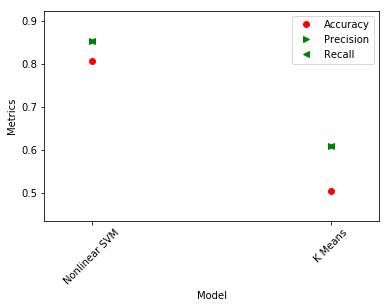

In [55]:
names = ["Nonlinear SVM" ,"K Means"]
acc_list = [poly_accuracy,km_accuracy]
pre_list = [poly_precision,km_precision]
re_list = [poly_recall,km_recall]
xaxisRange = range(2)
plt.xticks(xaxisRange, names, rotation=45)
# plt.legend()

plt.plot(xaxisRange,acc_list,'ro',color="Red",label="Accuracy")
plt.plot(xaxisRange,pre_list,'>',color="green",label="Precision")
plt.plot(xaxisRange,pre_list,'<',color="green",label="Recall")

plt.xlabel('Model')
plt.ylabel('Metrics')
plt.margins(0.2)
plt.subplots_adjust(bottom=0.15)
legend = plt.legend()
plt.show()

#### ii. What method gives the best results?  
Clearly the Nonlinear SVM has better results for metrics as compared to the other model which is K means.

#### iii. What feature(s) seem to be most consistently predictive of high crime rates? How reliable is this conclusion?

## Extra Credit

#### GradientBoostingClassifier

In [56]:
clf = GradientBoostingClassifier()
clf.fit(X_d, y_d)
#dirty dataset
acc_scores = cross_val_score(svmclf, X_d, y_d, cv=10, scoring='accuracy').mean()
pre_scores = cross_val_score(svmclf, X_d, y_d, cv=10, scoring='precision').mean()
rec_scores = cross_val_score(svmclf, X_d, y_d, cv=10, scoring='recall').mean()
print ('Accuracy for GradientBoostingClassifier(Dirty Data) is', acc_scores)
print ('Precision for GradientBoostingClassifier(Dirty Data) is', pre_scores)
print ('Recall for GradientBoostingClassifier(Dirty Data) is', rec_scores)




NameError: name 'svmclf' is not defined

In [ ]:
#clean dataset
clf.fit(X, y)
acc_scores = cross_val_score(svmclf, X, y, cv=10, scoring='accuracy').mean()
pre_scores = cross_val_score(svmclf, X, y, cv=10, scoring='precision').mean()
rec_scores = cross_val_score(svmclf, X, y, cv=10, scoring='recall').mean()
print ('Accuracy GradientBoostingClassifier(Clean Data) is', acc_scores)
print ('Precision GradientBoostingClassifier(Clean Data)is', pre_scores)
print ('Recall is GradientBoostingClassifier(Clean Data) is ', rec_scores)

In [ ]:
clf = RandomForestClassifier(random_state=100, max_depth=3)

rf_accuracy = cross_val_score(clf, X_d, y_d, cv=10, scoring='accuracy').mean()
rf_precision = cross_val_score(clf, X_d, y_d, cv=10, scoring='precision').mean()
rf_recall = cross_val_score(clf, X_d, y_d, cv=10, scoring='recall').mean()

print ('Accuracy for RandomForestClassifier is', rf_accuracy)
print ('Precision for RandomForestClassifier is', rf_precision)
print ('Recall for RandomForestClassifier is', rf_recall)

##### Random Classifier shows good results in terms of metrics and would be a good model to predict the crime data.

### Conclusion:

We have applied various models including: Decision Trees, Gaussian NB, Linear VNM, Regression, Linear SVM, Non linear SVM, K means, Gradient Boosting Classifier and Random Forests. We also performed the 10 fold cross validation. The results are different and we have plotted results based on the metrics for the different models. It can further be tested on many models to identify the best that can be used to predict the crime rate.